## **Artificial Neural Networks (ANN)**

We begin by importing numpy and setting up a random number generator rng, with a seed value of 42. 

This seed value will be used throughout the notebook to ensure reproducability of experiments.


In [1]:
import numpy as np 
rng = np.random.default_rng(seed=42)

import warnings 
warnings.filterwarnings('ignore')

### **Network Class**

We shall start writing the network class. The two methods that are indispensable for any ML class are : 

* `fit` 

* `predict` 

Fitting a neural network model requires us to compute **two passes** on the data : 

1. **forward** propagation 

2. **backward** propagation 

We need to start at some place by initializing the network and various hyperparameters and this requires an `init` method. 

In most of these methods, we would have to take the help of certain helper functions : 

* **activation** function 

* **loss** function 



This is the process. But we will work through it in reverse order so that each step of the process doesn't have any forward references : 

**helpers --> init --> forward --> backward --> fit --> predict**

The skeleton of the class is given in the code block that follows. 

For ease of of exposition, we are going to discuss the methods one at a time and then plug them into the class right at the end. 

In [2]:
class Network: 
    def init(self, layers, activation_choice = 'relu', output_choice='softmax', loss_choice='cce'):
        pass 

    def forward(self, X):
        pass 

    def backward(self, y,_y_hat):
        pass 

    def fit(self, X,y, lr=0.01, epochs=100, batch_size=100):
        pass

    def predict(self,X): 
        pass

### **Activation Functions**



#### **Hidden Layers**

We will look at two activation functions for the hidden layers. Both these functions will be applied function-wise. 

The input to these functions can **scalars, vectors or matrices**. 

1. **Sigmoid**

\begin{align}
\text {g}(z) = \frac{1}{1 + e^{-z}}
\end{align}

2. **Relu**


\begin{equation}
    \text {g} (z)=
    \begin{cases}
      z, \text { $z$ $\ge$ 0}\\
      0, \text { $z$ $<$ 0}
    \end{cases}
\end{equation}

We also need the derivatives of these functions while computing the backward pass. 

In [3]:
def sigmoid(z): 
    return 1 / (1 + np.exp(-z))

def grad_sigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

def relu(z):
    np.where(z>=0, z ,0)

def grad_relu(z):
    return np.where(z>=0 ,1,0)

hidden_act = {'sigmoid':sigmoid, 'relu':relu}
grad_hidden_act = {'sigmoid': grad_sigmoid, 'relu': grad_relu}


#### **Output Layers**

We will look at two activation functions for the **output layer** which are **identity for regression and softmax for classification**. 


1. **Identity** function (for **regression**)

\begin{align}
\text {g}(z) = \text {z}
\end{align}

2. **Softmax** function (for **classification**)


The input to the softmax function will always be a matrix of size n X k, where k is the number of classes. Since we need a probablity distribution for each datapoint , the softmax will be computed row wise.


\begin{equation} 
\text {softmax} \textbf (Z) = \frac{\text {exp} \textbf (Z)}{\sum \text {exp}(Z)}
\end{equation}

To avoid overflow, we will subtract the row-wise maximum from each row while computing the softmax.


In [4]:
def identity(z):
    return z 

def softmax(z):
    # check if z is a matrix
    assert z.ndim == 2

    # to prevent overflow, subtract max, row-wise
    z -= z.max(axis=1, keepdims = True)

    # Compute rowwise softmax
    prob = np.exp(z) / np.exp(z).sum(axis=1 ,keepdims = True)

    # check if each row is a probablity distribution 
    assert np.allclose(prob.sum(axis=1), np.ones(z.shape[0]))
    return prob

In [5]:
output_act = {'softmax':softmax, 'identity':identity}

### **Loss function**

There are two types of losses we will use, **least square error for regression** and **categorical cross-entropy for classification**.

1. **Least Square Error (LSE)**

* **y** is a vector of target labels for *n* datapoints. 

* **ŷ** is the output of the network and corresponds to the predicted labels. 

\begin{align}
\text{L} (y, ŷ) = \frac{1}{2} (ŷ - y)^{\intercal} (ŷ - y)
\end{align}

2. **Categorical Cross-Entropy (CCE)**

* **Y** is a matrix of target labels for *n* datapoints. 

* **Ŷ** is the output of the network and corresponds to the predicted labels. 

\begin{align}
\text{L} (Y, Ŷ) = -1_{n}^T (\text {Y} ⊙ \text {log} \text {Ŷ}) 1_k
\end{align}

In our implementation, we will assume that the arguments to the loss function are always matrices of size **n X k**. 

In the case of regression, **k=1**.

In [6]:
def least_square(y, y_hat):
    return 0.5 * np.sum(np.transpose(y-y_hat) * (y-y_hat))

def cce(Y, Y_hat):
    return -np.sum(Y * np.log(Y_hat))

losses = {'least_square':least_square , 'cce':cce}

### **Initilization**

Here we will look at two parts : 

* Network architechture 

* Weight Initialization 

#### **Network architechture**

The following components mainly determine the structure of the network : 

* number of layers 

* number of neurons per layer 

We will use *l* to index the layers. The network has *L* layers in all. 

* *l* = 0 : **Input Layer** 

* 1 <= *l* <= *L*-1 : **Hidden Layers** 

* *l* = *L* : **Output Layer** 

We shall represent the number of layers and the neurons using a list layers. The variable *L* will never make an explicit appearance anywhere, instead we will use **range(len(layers))** to iterate  through the layers.

One useful task is to **compute the total number of parameters in the network**. 

In [7]:
def count_params(layers):
    num_params = 0 
    for l in range(1 ,len(layers)): 
        num_weights = layers[l-1] * layers[l]
        num_biases = layers[l]
        num_params += (num_weights + num_biases)
    return num_params

# Test count_params 
assert count_params([64,5,10]) == (64 * 5 + 5) + (5 * 10 + 10)

### **Parameter initialization**

The weight-matrix at layer *l* has a size of `layers[l - 1]` X `layers[l]`.

The bias at layer *l* has a size of `layers[l]`.

We will store all these weights in a list `w` of the same size as `layers`. `W[l]` would correspond to **W_l**.

Since there are *L* weight matrices, W[0] would be set to `None`. Recall that the size of the list is `L+1`. A similar list wolud be required for `b`.

To make the gradient descent update simpler, it will be useful to have a **master vector, θ**, that has a reference to all the parameters in the network. 

We will do the same for the **gradient θ(x)**. So, **whenever θ is updated, the weights W1 will also be updated** and vice-versa.

One way to do this is to **first start with the master vector and then reshape chunks of it into the dimensions of a weight matrix**. 

Reshaping an array usually returns a view of an array and not a copy. 

To understand this function better, refer to Numpy's documentation on "[**Copies and Views**](https://numpy.org/doc/stable/user/basics.copies.html)". 



In [8]:
def init_params(layers):
    # number of params in the n/w
    num_params = count_params(layers)

    # weights
    W = [None for _ in range(len(layers))]
    # biases    
    b = [None for _ in range(len(layers))]
    # gradient loss w.r.t weights    
    gW = [None for _ in range(len(layers))]
    # gradient loss w.r.t biases
    gb = [None for _ in range(len(layers))]

    # sample from N(0,1) to initialize the params 
    theta = rng.standard_normal(num_params)
    g_theta = np.zeros(num_params)

    # (start, end) specify the portion of theta that corresponds to the prameter W_l and b_l. 
    start, end = 0 ,0
    for l in range(1, len(layers)):
        # reshape the section (start, end) and assign it to W[l]
        end = start + layers[l-1] * layers[l]
        W[l] = theta[start:end].reshape(layers[l-1], layers[l])
        gW[l] = g_theta[start:end].reshape(layers[l-1], layers[l])

        # reshape the section (start, end) and assign it to b[l]
        start, end = end, end + layers[l]
        b[l] = theta[start:end].reshape(layers[l])
        gb[l] = g_theta[start:end].reshape(layers[l])
        start = end

    return theta, g_theta, W, b, gW, gb

Test init params

In [9]:
layers = [64, 32, 10]
params = init_params([64, 32, 10])
for l in range(1, len(layers)):
    # check if the weights are views of the master vector 
    assert params[2][1].base is params[0]
    assert params[3][1].base is params[0]
    assert params[4][1].base is params[1]
    assert params[5][1].base is params[1]

We are now ready to initialize the network.

In [10]:
def init(self, layers, activation_choice='relu', output_choice='softmax',loss_choice='cce'):
    self.layers = layers 

    # Parameters and gradients 
    self.theta, self.g_theta, \
    self.W, self.b, \
    self.gW, self.gb = init_params(layers)

    #activation functions 
    self.ghid = hidden_act[activation_choice]
    self.grad_ghid = grad_hidden_act[activation_choice]
    self.gout = output_act[output_choice]

    # loss 
    self.loss = losses[loss_choice]

### **Forward Pass**

The forward algorithm is as follows : 

First we initialize **$A_0$ = $X$**. Then, we iteratively compute the pre activations and the activations for every layer $l$ using the equations given below : 

\begin{align}
Z_1 = A_{l-1}W_1 + b_1
\end{align}

\begin{align}
A_l = g(Z_1)
\end{align}

Finally the network's output is given by : $ŷ$ = $A_L$

In [11]:
def forward(self,X):
    self.z = [None for _ in range(len(self.layers))]
    self.A = [None for _ in range(len(self.layers))]
    self.A[0] = X
    self.z[0] = X

    for l in range(1, len(self.layers)):
        self.z[l] = self.A[l - 1] @ self.W[l] + self.b[l]
        self.A[l] = self.ghid(self.z[l])

    self.A[-1] = self.gout(self.z[-1])
    return self.A[-1]

### **Backward Pass**

The backward pass algorithm is as follows : 

We first initialize the gradients of the pre-activation at layer $L$ as $Z_L^{(g)}$ = $Ŷ$ - $Y$.

It is fortunate that this true for both regression and classification. 

The other gradients can be iteratively updated using these equations. 

\begin{align}
W_l^{(g)} = A_{l-1}^{\intercal} . Z_l^{(g)}
\end{align}

\begin{align}
b_l^{(g)} = {Z_l^{(g)}}^{\intercal} 1_a
\end{align}

\begin{align}
A_{l - 1}^{(g)} = Z_{l}^{(g)} .{ W_l}^{\intercal}
\end{align}

\begin{align}
Z_{l - 1}^{(g)} = A_{l - 1}^{(g)} ⊙ g' (Z_{l - 1})
\end{align}

An important point to note is the use of `self.gW[l][:, :]` , while updating the gradient of the weights and not `self.gW[l] . self.gW[l][:, :] ` does an in-place update, thus maintaining a link with the master params, namely `self.theta`.


In [12]:
def backward(self, Y, Y_hat):
    gZ = [None for _ in range(len(self.layers))]
    gA= [None for _ in range(len(self.layers))]
    gZ[-1] = Y_hat - Y

    for l in range(len(self.layers) - 1, 0, -1):
        self.gW[l][:, :] = self.A[l - 1].T @ gZ[l]
        self.gb[l][:] = np.sum(gZ[l].T, axis=1)
        gA[l - 1] = gZ[l] @ self.W[l].T
        gZ[l - 1] = gA[l - 1] * self.grad_ghid(self.z[l - 1])

### **Fit**

We now have all the ingredient sto fit a model using gradient descent. We will use **mini-batch gradient descent**. 

The **batch size**, **learning rate** and the **number of epochs** will be the hyperparameters.

In [13]:
def fit(self, X,Y,lr=0.01, epochs=100, batch_size=100):
    self.losses = []

    for epoch in range(epochs):
        # compute loss 
        Y_hat = self.forward(X)
        self.losses.append(self.loss(Y, Y_hat))

        # shuffle the dataset 
        indices = np.arange(X.shape[0])

        # use rng.shuffle to maintain reproductability 
        rng.shuffle(indices)
        X, Y = X[indices], Y[indices]

        # number of batches 
        num_batches = X.shape[0] // batch_size 

        # mini batch GD 
        for b in range(num_batches):
            Xb = X[b * batch_size: (b + 1) * batch_size]
            Yb = Y[b * batch_size: (b + 1) * batch_size]

            # compute the predictions for this batch 
            Y_hat_b = self.forward(Xb)
            # compute the gradients for this batch 
            self.backward(Yb, Y_hat_b)
            # update the gradients of all parameters 
            # -= is used for in-place update 
            self.theta -= lr * self.g_theta

### **Predict**

Finally, we can use a trained model to predict the labels. 

In [14]:
def predict(self, X):
    Y_hat = self.forward(X)
    # for regression 
    if X.shape[-1] == 1:
        return Y_hat
    # for classification 
    else : 
        return np.argmax(Y_hat, axis=1)

### **Plugging in all functionalities**

We can now plug all of this into our class. 

In [15]:
Network.__init__ = init 
Network.forward = forward 
Network.backward = backward 
Network.fit = fit 
Network.predict = predict

### **Dealing with Data**

We will import the digits dataset from `sklearn` class. 

In [16]:
from sklearn.datasets import load_digits
digits = load_digits()

In [17]:
X = digits.images
y = digits.target

X.shape, y.shape

((1797, 8, 8), (1797,))

##### **Normalize the data so that all features lie in (0,1).**

In [18]:
X /= np.max(X)

##### **Plotting the images.**

In [19]:
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

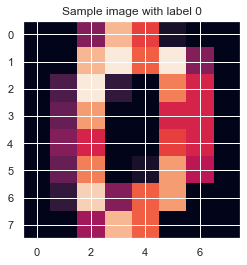

In [20]:
plt.imshow(X[0])
plt.title(f'Sample image with label {y[0]}')
plt.show()

##### **Reshaping Input.**

In [21]:
X = X.reshape(-1, 64)
X.shape

(1797, 64)

In [22]:
# input size
isize = X.shape[-1]
# output size
osize = len(np.unique(y))

##### **Dealing with one hot encoding**

In [23]:
def one_hot_encoder(y):
    k = len(np.unique(y))
    return np.eye(k)[y]

##### **Train test split**

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

y_train = one_hot_encoder(y_train)
y_test = one_hot_encoder(y_test)

print('Training data shape : ', X_train.shape, y_train.shape)
print('Testing data shape : ', X_test.shape, y_test.shape)


Training data shape :  (1078, 64) (1078, 10)
Testing data shape :  (719, 64) (719, 10)


##### **Applying Fit method.**

In [25]:
layers = [isize, 32, osize]
network = Network(layers, activation_choice='sigmoid', output_choice='softmax',loss_choice='cce')

# fit the network on the data 
epochs = 50 
network.fit(X_train, y_train, lr=0.01, epochs=epochs, batch_size=10)


##### **Plotting the losses.** 

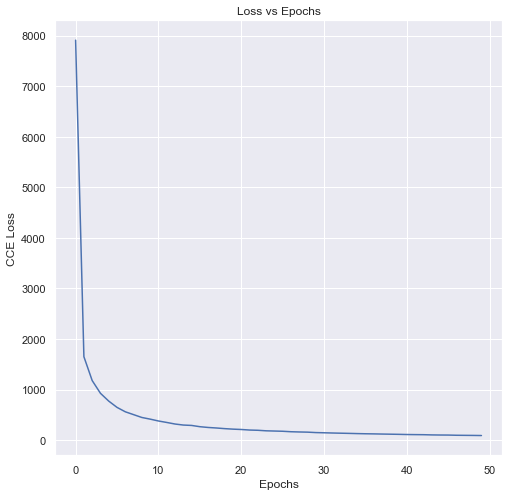

In [26]:
plt.figure(figsize=(8,8))
plt.plot(range(epochs), network.losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('CCE Loss')
plt.show()

#### **Computing the accuracy.**

In [27]:
print(f'Test data size = {X_test.shape[0]}')
print(f'Number of parameters = {count_params(layers)}')

Test data size = 719
Number of parameters = 2410


In [28]:
accuracy = np.sum(network.predict(X_test) == y_test) / X_test.shape[0] * 100
print(f'Accuracy = {accuracy:.2f}')

Accuracy = 0.00
